<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/pendulumExample4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIA3: Trabajo Módulo Reinforcement Learning
#Trabajo: GymLibray/Classic Control/Pendulum
###Alumno: Álvaro Uriel Cárcel


#Introducción

En el presente trabajo se tratará de resolver un Clásico Entorno de Teoria de Contról de la libreria Gym. Para ello se emplearán algoritmos de Machine Learning, concretamente algoritmos de Aprendizaje Reforzado o Reinforcement learning.

El Entorno que se ha elegido para el desarrollo del trabajo es 'Pendulum'. Este entorno tiene cierta similitud con los que se han trabajado en las clases como son 'Cart Pole' y 'Mountain Car', a priori se podría decir que son de dificultad similar a la hora de su resolución, es por ello que se ha decido emplear este Entorno para el Trabajo. Como su nombre indica el entorno consiste en un Péndulo Invertido que inicia en una posición aleatoria y está sujeto a las leyes de la gravedad, el desafio se evalua contabilizando el tiempo que se ha conseguido mantener el pendulo con su centro de masas por encima del punto fijo respecto a al tiempo del episodio.


https://www.gymlibrary.ml/environments/classic_control/pendulum/

###Espacio de Acciones:
* Se puede actuar sobre el Torque del Péndulo en el intervalo [-2,2].


###Espacio de Observación:
Se puede observar 3 variables: las coordenadas x-y y la velocidad angular de su extremo libre.

* x = cos(theta) [-1.0, 1.0]

* y = sin(angle) [-1.0, 1.0]

* Angular Velocity [-8.0, 8.0]

###Recompensas:
* r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)


In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from keras import Sequential
from collections import deque
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
def muestra_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("No se encontro el video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [4]:
env = wrap_env(gym.make('Pendulum-v0'))
env.seed(0)
np.random.seed(0)
display = Display(visible=0)
display.start()

#Selección de Algoritmo:
Para la resolución del problema se ha optado por probar el algoritmo ya visto en clase, DQN. Esta tipología de algoritmos combina Q-Learning y Redes profundas por lo que a priori deberíamos tener la capacidad de resolver nuestro problema con él ya que se trata de uno de los más "sencillos" que encontramos en la librería GYM.

Tanto los parámetros de explotación-exploración como los referentes al Modelo de Red Neuronal han sido testeados con diversos valores y tras varias pruebas estos que se ven acontinuación han sido los elegidos para una correcta resolución del Entorno.




In [5]:
class DQN:

    def __init__(self, action_space, state_space):

        self.action_space      = action_space
        self.state_space       = state_space
        
        self.gamma             = 0.95    # Discount factor for estimaing the futures rewards
        self.batch_size        = 64      # Size of the batch when sampling experiences

        self.epsilon           = 1       # Initial probability for choosing exploration instead of explotation 
        self.epsilon_min       = 0.1    # Last probability for choosing exploration instead of explotation 
        self.approx_iterations = 200     # This is an estimation of the training iterations to tune the epsilon decay

        # The epsilon_decay reduce the exploration probability after each iteration
        self.epsilon_decay = (self.epsilon_min / self.epsilon) ** (1 / self.approx_iterations)
        self.learning_rate = 0.005       # The usual factor that controls the amount of change the weights are updated

        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(12, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [6]:

def train_dqn(episode):
    global env
    loss = []
    agent = DQN(5, env.observation_space.shape[0])

    for e in range(episode):

        figure, axis = plt.subplots(2)
        axis[0].set_ylim([-1, 1])

        temp=[]
        tempTorque=[]
        state = env.reset()
        state = np.reshape(state, (1, 3))
        score = 0
        maxp = -1.2
        max_steps = 1000

        for i in range(max_steps):

            env.render()
            action = agent.act(state)
            torque = [-2+action]
            next_state, reward, done, _ = env.step(torque)
            next_state = np.reshape(next_state, (1, 3))

            if (next_state[0,0]>0.95):
                score=score+1

            maxp = max(maxp, next_state[0,0])
            temp.append(next_state[0,0])
            tempTorque.append(torque)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            if done:

                print("Episodio: {}/{}, Score: {}".format(e, episode, score))
                print("Max X: ", maxp)      
                print("Graficas de 'X' y 'Torque':")      
                axis[0].plot([i for i in range(0, 200, 1)], temp[::1])               
                axis[1].plot([i for i in range(0, 200, 1)], tempTorque[::1])

                plt.show()
                env.close()
                muestra_video()
                env = wrap_env(gym.make('Pendulum-v0'))
                env.seed(episode)
                print("")

                break

        loss.append(score)

    return loss, temp, tempTorque

#Entrenamiento:
En cuanto al entrenamiento se han seleccionado 25 episodios ya que tras el tuneado del algoritmo se ha visto que son suficientes para obtener una correcta solución del problema.

Episodio: 0/25, Score: 0
Max X:  0.2014596086501165
Graficas de 'X' y 'Torque':


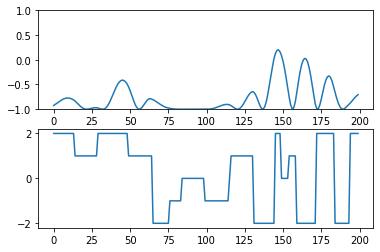


Episodio: 1/25, Score: 20
Max X:  0.9999993371474859
Graficas de 'X' y 'Torque':


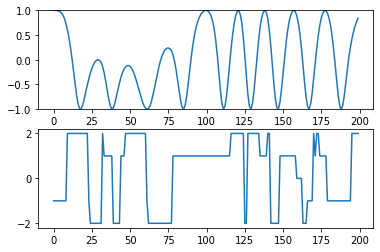


Episodio: 2/25, Score: 12
Max X:  0.9992583431124867
Graficas de 'X' y 'Torque':


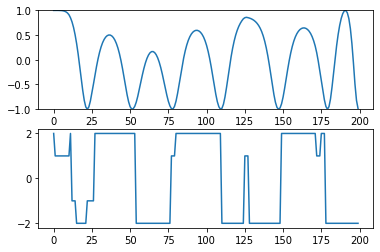


Episodio: 3/25, Score: 71
Max X:  0.9999087637000382
Graficas de 'X' y 'Torque':


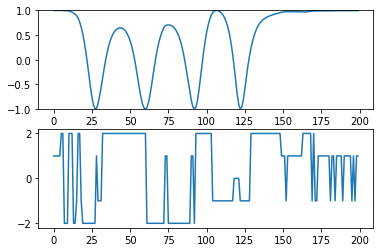


Episodio: 4/25, Score: 69
Max X:  0.9999995992228697
Graficas de 'X' y 'Torque':


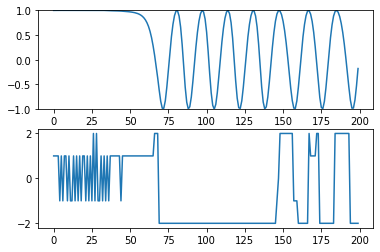


Episodio: 5/25, Score: 26
Max X:  0.9999513317868196
Graficas de 'X' y 'Torque':


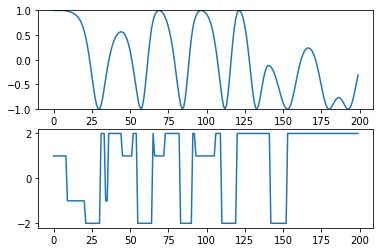


Episodio: 6/25, Score: 47
Max X:  0.9999087637000382
Graficas de 'X' y 'Torque':


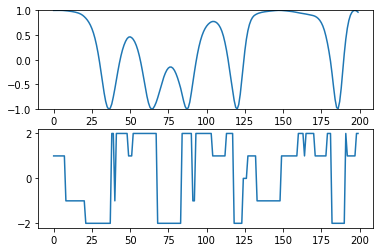


Episodio: 7/25, Score: 32
Max X:  0.9999937621609907
Graficas de 'X' y 'Torque':


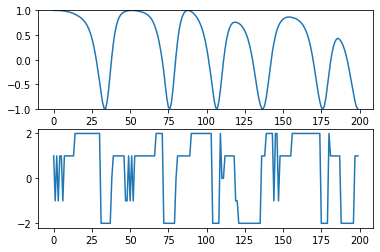


Episodio: 8/25, Score: 63
Max X:  0.9999915648814346
Graficas de 'X' y 'Torque':


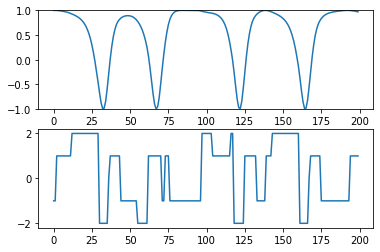


Episodio: 9/25, Score: 40
Max X:  0.9999708934141841
Graficas de 'X' y 'Torque':


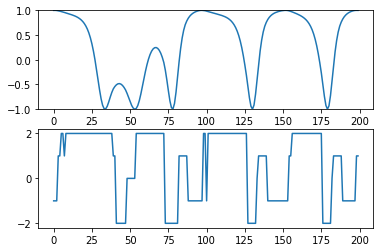


Episodio: 10/25, Score: 107
Max X:  0.999774240747792
Graficas de 'X' y 'Torque':


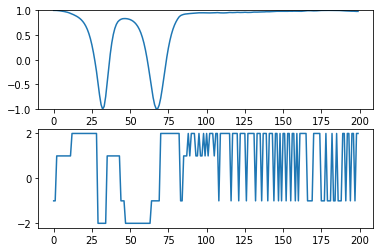


Episodio: 11/25, Score: 66
Max X:  0.9999992179556093
Graficas de 'X' y 'Torque':


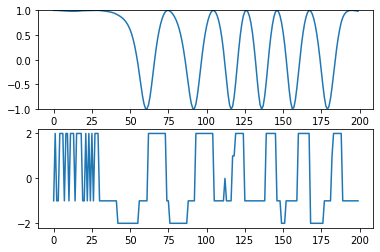


Episodio: 12/25, Score: 137
Max X:  0.999921215168397
Graficas de 'X' y 'Torque':


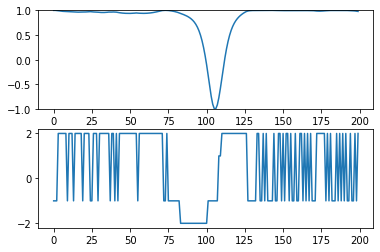


Episodio: 13/25, Score: 111
Max X:  0.999774240747792
Graficas de 'X' y 'Torque':


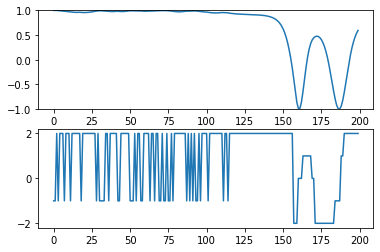


Episodio: 14/25, Score: 106
Max X:  0.9999883297887058
Graficas de 'X' y 'Torque':


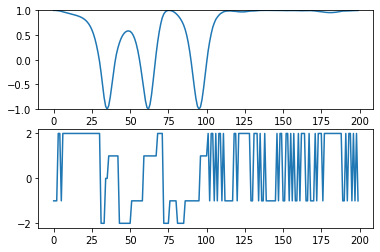


Episodio: 15/25, Score: 200
Max X:  0.9999994898988482
Graficas de 'X' y 'Torque':


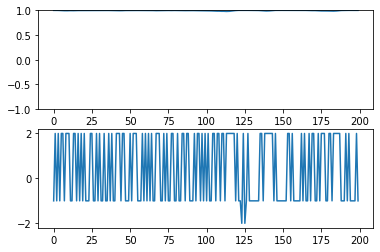


Episodio: 16/25, Score: 154
Max X:  0.999999924052171
Graficas de 'X' y 'Torque':


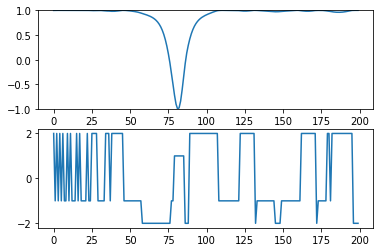


Episodio: 17/25, Score: 188
Max X:  0.9999999608343727
Graficas de 'X' y 'Torque':


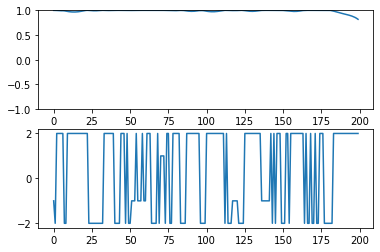


Episodio: 18/25, Score: 200
Max X:  0.9999998957470688
Graficas de 'X' y 'Torque':


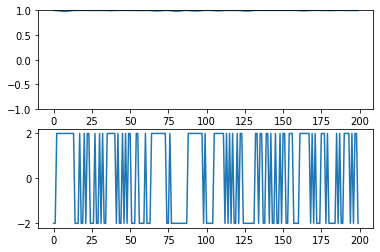


Episodio: 19/25, Score: 200
Max X:  0.9999999996934968
Graficas de 'X' y 'Torque':


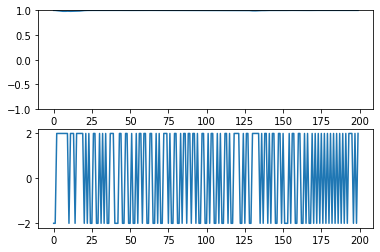


Episodio: 20/25, Score: 200
Max X:  0.9999999970438629
Graficas de 'X' y 'Torque':


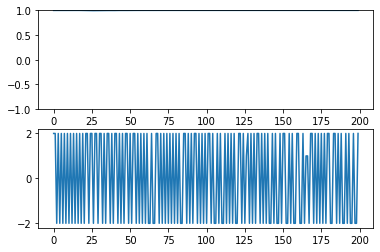


Episodio: 21/25, Score: 200
Max X:  0.9999999997654143
Graficas de 'X' y 'Torque':


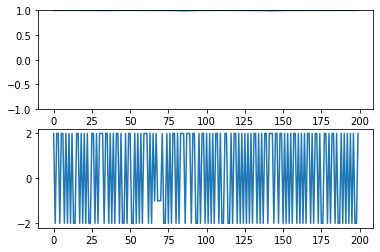


Episodio: 22/25, Score: 200
Max X:  0.9999998088318477
Graficas de 'X' y 'Torque':


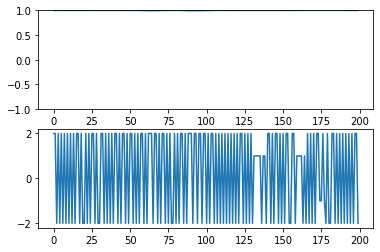


Episodio: 23/25, Score: 200
Max X:  0.9999999090759429
Graficas de 'X' y 'Torque':


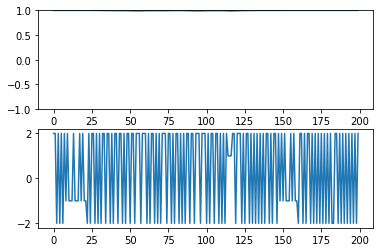


Episodio: 24/25, Score: 200
Max X:  0.9999638456528465
Graficas de 'X' y 'Torque':


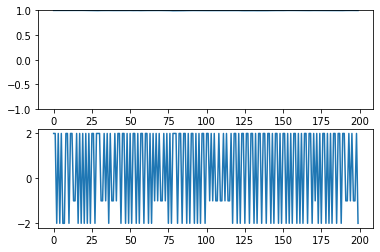

In [7]:
if __name__ == '__main__':
    ep = 25
    loss, lastTemp, lastTorque  = train_dqn(ep)

#Conlusión 
Tras el desarrollo del trabajo se puede concluir que el algoritmo consigue aprender a resolver la tarea en función de las recompensas establecidas en el Entorno. Aquí se prensentan tanto la evolución, medida en Score de los distintos episodios, como la observación de la variable X y la acción de Torque en el último episodio, ya que se entiende que será en éste en el que el algoritmo puede explotar al máximo todo lo aprendido previamente.

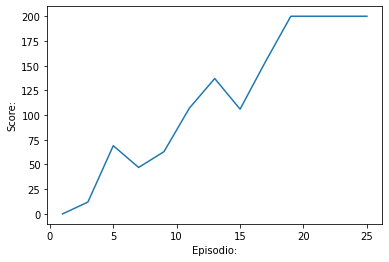

In [8]:
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.xlabel('Episodio:')
    plt.ylabel('Score:')
    plt.show()

Graficas de Último 'X' y 'Torque':


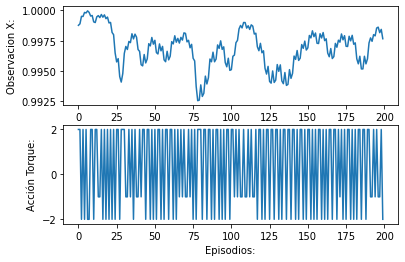

In [9]:
print("Graficas de Último 'X' y 'Torque':") 
figure1, axis1 = plt.subplots(2)

axis1[0].set(ylabel="Observacion X:", xlabel="Episodios:")
axis1[1].set(ylabel="Acción Torque:", xlabel="Episodios:")

axis1[0].plot([i for i in range(0, 200, 1)], lastTemp[::1])               
axis1[1].plot([i for i in range(0, 200, 1)], lastTorque[::1])